In [47]:
!git clone https://github.com/GKPr0/Self-Driving-Car-Simulation.git 

fatal: destination path 'Self-Driving-Car-Simulation' already exists and is not an empty directory.


In [48]:
import os
import cv2
import ntpath
import random
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



In [49]:
# Loading training data labels
data_dir = 'Self-Driving-Car-Simulation/Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse','speed']
data = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/center_2020_11_22_18_26_19_522.jpg,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/left_2020_11_22_18_26_19_522.jpg,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/right_2020_11_22_18_26_19_522.jpg,0.0,0.0,0,0.000078
1,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/center_2020_11_22_18_26_19_624.jpg,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/left_2020_11_22_18_26_19_624.jpg,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/right_2020_11_22_18_26_19_624.jpg,0.0,0.0,0,0.000081
2,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/center_2020_11_22_18_26_19_739.jpg,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/left_2020_11_22_18_26_19_739.jpg,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/right_2020_11_22_18_26_19_739.jpg,0.0,0.0,0,0.000078
3,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/center_2020_11_22_18_26_19_857.jpg,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/left_2020_11_22_18_26_19_857.jpg,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/right_2020_11_22_18_26_19_857.jpg,0.0,0.0,0,0.000078
4,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/center_2020_11_22_18_26_19_971.jpg,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/left_2020_11_22_18_26_19_971.jpg,/home/formule1/Self-Driving-Car-Simulation/Data/IMG/right_2020_11_22_18_26_19_971.jpg,0.0,0.0,0,0.000079


In [50]:
# Extracting img name from img path
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_11_22_18_26_19_522.jpg,left_2020_11_22_18_26_19_522.jpg,right_2020_11_22_18_26_19_522.jpg,0.0,0.0,0,0.000078
1,center_2020_11_22_18_26_19_624.jpg,left_2020_11_22_18_26_19_624.jpg,right_2020_11_22_18_26_19_624.jpg,0.0,0.0,0,0.000081
2,center_2020_11_22_18_26_19_739.jpg,left_2020_11_22_18_26_19_739.jpg,right_2020_11_22_18_26_19_739.jpg,0.0,0.0,0,0.000078
3,center_2020_11_22_18_26_19_857.jpg,left_2020_11_22_18_26_19_857.jpg,right_2020_11_22_18_26_19_857.jpg,0.0,0.0,0,0.000078
4,center_2020_11_22_18_26_19_971.jpg,left_2020_11_22_18_26_19_971.jpg,right_2020_11_22_18_26_19_971.jpg,0.0,0.0,0,0.000079


In [51]:
# Optimize steering angle distibution by setting maximum number of records for each angle
remove_list = []

num_bins = 25
samples_per_bin = 250

hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5

print('total data', len(data))

for i in range(num_bins):
  list_ = []
  for j in range(len(data['steering'])):
    if data['steering'][j] >= bins[i] and data['steering'][j] <= bins[i+1]:
      list_.append(j)

  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed', len(remove_list))

data.drop(data.index[remove_list], inplace=True)

print("remaining data:", len(data))

hist_new, _ = np.histogram(data['steering'], num_bins)



total data 5487
removed 3947
remaining data: 1540


In [52]:
# Loading training images and assigning them to appropriate steering angle
def load_img_steering(data_dir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0:3]
    image_path.append(os.path.join(data_dir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)

  return image_paths, steerings

image_paths, steerings = load_img_steering(data_dir + '/IMG', data)

In [53]:
# Splitting data to training and validation set
X_train_raw, X_val_raw, Y_train_raw, Y_val_raw = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print("Training sample: {} \n Valid samples: {}".format(len(X_train_raw), len(X_val_raw)))

Training sample: 1232 
 Valid samples: 308


In [54]:
# Preprocessing images
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:136, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img / 255
  return img


X_train = np.array(list(map(img_preprocess, X_train_raw)))
X_val = np.array(list(map(img_preprocess, X_val_raw)))

Y_train = Y_train_raw
Y_val = Y_val_raw

In [55]:
# Creating Nvidia model
model = Sequential()

model.add(Convolution2D(24, kernel_size=(5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='relu'))
model.add(Convolution2D(36, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
model.add(Convolution2D(48, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
model.add(Convolution2D(64, kernel_size=(3, 3), activation='elu'))
model.add(Convolution2D(64, kernel_size=(3, 3), activation='elu'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))

model.add(Dense(50, activation='elu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='elu'))
model.add(Dropout(0.5))

model.add(Dense(1))

optimizer = Adam(lr=1e-3)

model.compile(optimizer, loss='mse')

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

In [56]:
# Train model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, batch_size=100, shuffle=1, verbose=1)

Epoch 1/30
13/13 [==============================] - 0s 35ms/step - loss: 0.3824 - val_loss: 0.0805
Epoch 2/30
13/13 [==============================] - 0s 22ms/step - loss: 0.0946 - val_loss: 0.0799
Epoch 3/30
13/13 [==============================] - 0s 20ms/step - loss: 0.0909 - val_loss: 0.0793
Epoch 4/30
13/13 [==============================] - 0s 19ms/step - loss: 0.0892 - val_loss: 0.0769
Epoch 5/30
13/13 [==============================] - 0s 19ms/step - loss: 0.0872 - val_loss: 0.0730
Epoch 6/30
13/13 [==============================] - 0s 20ms/step - loss: 0.0865 - val_loss: 0.0679
Epoch 7/30
13/13 [==============================] - 0s 21ms/step - loss: 0.0804 - val_loss: 0.0655
Epoch 8/30
13/13 [==============================] - 0s 19ms/step - loss: 0.0775 - val_loss: 0.0583
Epoch 9/30
13/13 [==============================] - 0s 20ms/step - loss: 0.0751 - val_loss: 0.0573
Epoch 10/30
13/13 [==============================] - 0s 19ms/step - loss: 0.0688 - val_loss: 0.0453
Epoch 11/

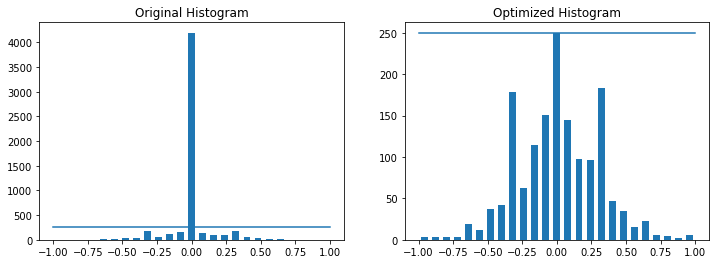

In [57]:
# Plotting steering angle distribution before and after optimalization
fig, axs = plt.subplots(1,2, figsize=(12, 4))

axs[0].set_title("Original Histogram")
axs[0].bar(center, hist, width=0.05)
axs[0].plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

axs[1].set_title("Optimized Histogram")
axs[1].bar(center, hist_new, width=0.05)
axs[1].plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Text(0.5, 1.0, 'Preprocessed Image Shape:(66, 200, 3)')

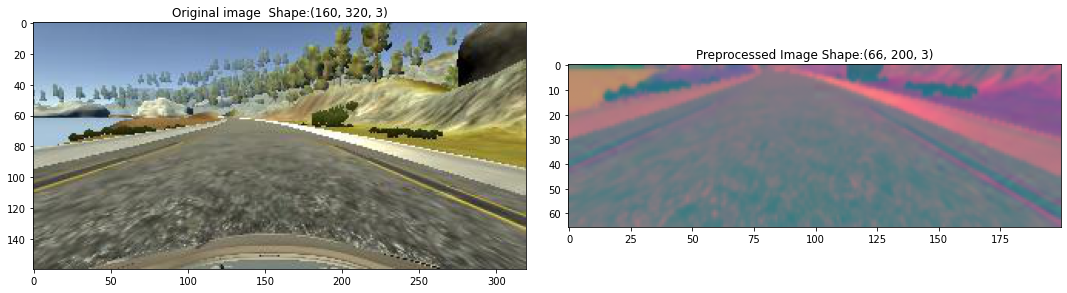

In [58]:
# Plotting Image before and after preprocessing
img_index = random.randint(0, len(X_train)-1)
original_img = mpimg.imread(X_train_raw[img_index])
preprocessed_img = X_train[img_index]

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_img)
axs[0].set_title("Original image  Shape:{}".format(original_img.shape))

axs[1].imshow(preprocessed_img)
axs[1].set_title("Preprocessed Image Shape:{}".format(preprocessed_img.shape))

Text(0.5, 1.0, 'Validation set')

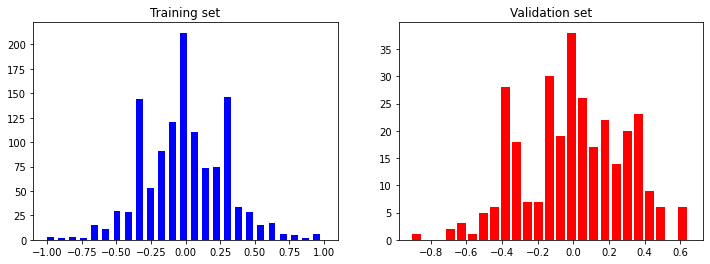

In [59]:
# Plotting steering angle distibution in train and val dataset
fig, axs = plt.subplots(1,2, figsize=(12, 4))

axs[0].hist(Y_train_raw, bins=num_bins, width=0.05, color='b')
axs[0].set_title("Training set")

axs[1].hist(Y_val_raw, bins=num_bins, width=0.05, color='r')
axs[1].set_title("Validation set")

Text(0.5, 1.0, 'Train loss vs Validation loss')

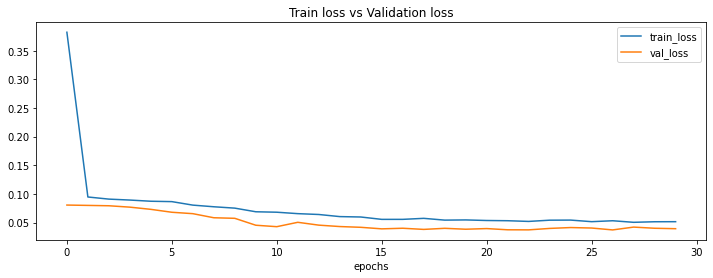

In [63]:
# Plotting model loss
plt.figure(figsize=(12, 4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train_loss", "val_loss"])
plt.xlabel("epochs")
plt.title("Train loss vs Validation loss")

In [ ]:
# Save model
model.save('model.h5')
files.download('model.h5')